# CIFAR-10 DataSet Neural Net From Scratch

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import zipfile
import pickle
import os
import random

%matplotlib inline

In [27]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

## Importing, Viewing and Splitting Data

In [28]:
with zipfile.ZipFile('/content/drive/MyDrive/Copy of cifar-10-batches.zip', 'r') as f:
    f.extractall('/content/drive/MyDrive/')

In [29]:
def unpickle(f):
    with open(f, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    print(f"unpickled {f}")
    return d

In [30]:
# UNPICKLING DATA AND STORING IN BATCHES
batches = []
for f in os.listdir('/content/drive/MyDrive/cifar-10-batches'):
    file_name = os.fsdecode(f)
    if not (file_name.endswith(".meta") or file_name.endswith(".md")):
        batches.append(unpickle(f"/content/drive/MyDrive/cifar-10-batches/{f}"))

unpickled /content/drive/MyDrive/cifar-10-batches/data_batch_3
unpickled /content/drive/MyDrive/cifar-10-batches/data_batch_1
unpickled /content/drive/MyDrive/cifar-10-batches/data_batch_5
unpickled /content/drive/MyDrive/cifar-10-batches/data_batch_6
unpickled /content/drive/MyDrive/cifar-10-batches/data_batch_2
unpickled /content/drive/MyDrive/cifar-10-batches/data_batch_4


In [31]:
batches_meta_unpickled = unpickle('/content/drive/MyDrive/cifar-10-batches/batches.meta')

unpickled /content/drive/MyDrive/cifar-10-batches/batches.meta


In [32]:
print(batches[0].keys())
print(batches[0][b'batch_label']) # 5 training batches and 6th one for testing
print(batches[5][b'batch_label'])
print(f"number of samples {len(batches[0][b'data'])}")

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
b'training batch 3 of 5'
b'training batch 4 of 5'
number of samples 10000


In [33]:
# b'labels' and b'data' are the main things we need
batches[0][b'data'][0].shape  # each array is 1024 in length, representing a 32 x 32 Grey scaled image

(1024,)

In [34]:
# LABELS
labels_dict = {}
for x in range(10):
    labels_dict[x] = batches_meta_unpickled[b'label_names'][x]
labels_dict

{0: b'airplane',
 1: b'automobile',
 2: b'bird',
 3: b'cat',
 4: b'deer',
 5: b'dog',
 6: b'frog',
 7: b'horse',
 8: b'ship',
 9: b'truck'}

In [35]:
# VIEWING IMAGES AND THEIR LABELS -> run each time for a new image
IMAGE_NUM = random.randint(0,10000)
print(f"Image num {IMAGE_NUM}")
image = batches[0][b'data'][IMAGE_NUM].reshape(32,32)
plt.imshow(image, cmap=plt.get_cmap('gray'))
print(f"LABEL -> {labels_dict[batches[0][b'labels'][IMAGE_NUM]]}")

Image num 1790
LABEL -> b'frog'


In [36]:
# CREATING TRAINING AND TEST SET
# Batch 1, 2, 3, 4, 5 --> train
# Batch 6 -> test
x_train_full = []
y_train_full = []
x_test, y_test = [], []
for indx in range(6):
    if batches[indx][b'batch_label'].startswith(b'training'): 
        x_train_full.extend(batches[indx][b'data'])
        y_train_full.extend(batches[indx][b'labels'])
    else:
        x_test.extend(batches[indx][b'data'])
        y_test.extend(batches[indx][b'labels'])

x_train = x_train_full
y_train = y_train_full
# # creating batches of size 32
# for x in range(0,len(x_train_full)):
#     if x % 32 == 0:
#         if x != 0:
#             x_train.append(x_temp)
#             y_train.append(y_temp)
#         x_temp = []
#         y_temp = []
#     x_temp.append(x_train_full[x])
#     y_temp.append(y_train_full[x])

x_train, y_train = np.array(x_train).astype(np.float32), np.array(y_train)
x_test, y_test = np.array(x_test).astype(np.float32), np.array(y_test)
print(len(x_train), len(y_train))

50000 50000


In [37]:
#normalising values
norm_x_train = np.linalg.norm(x_train)
norm_x_test = np.linalg.norm(x_test)

x_train /= norm_x_train
x_test /= norm_x_test

In [38]:
x_train

array([[2.4554189e-05, 1.6369459e-05, 1.1254003e-05, ..., 1.2277094e-05,
        1.1254003e-05, 1.2277094e-05],
       [8.6962747e-05, 9.2078204e-05, 8.5939660e-05, ..., 1.6881005e-04,
        1.7085622e-04, 1.4118658e-04],
       [1.8824877e-04, 1.6574077e-04, 1.7187932e-04, ..., 2.5577279e-04,
        2.5577279e-04, 2.5577279e-04],
       ...,
       [1.4834822e-04, 1.4220967e-04, 1.2481712e-04, ..., 1.4630203e-04,
        1.5653294e-04, 1.4425586e-04],
       [7.3662566e-05, 7.5708747e-05, 7.6731834e-05, ..., 5.0131468e-05,
        6.4454747e-05, 5.3200740e-05],
       [2.5168044e-04, 2.5270352e-04, 2.5270352e-04, ..., 1.8211023e-04,
        1.7494860e-04, 1.7085622e-04]], dtype=float32)

In [39]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

50000 50000
10000 10000


## Neural Net From Scratch

In [40]:
class Dense_Layer:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0):
        # initialising weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
    
    def forward(self, inputs):
        self.inputs = inputs
        # Output vals w/ inputs weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
    
    def backward (self, dvalues):
        #gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # regularization gradients
        # L1 weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weight)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        
        # L2 weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        
        # L1 biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        
        # L2 biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

        #gradeient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [41]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        # output vals from input
        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        # negative vals have zero gradient
        self.dinputs[self.inputs <= 0] = 0

In [42]:
class Layer_Dropout:
    def __init__(self, rate):
        # rate -> we give the amount that we want to droupout / since we want success rate we subtract by 1
        self.rate = 1 - rate
    
    def forward(self, inputs):
        self.inputs = inputs
        # scaled mask
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        # applying mask to output 
        self.output = inputs * self.binary_mask
    
    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

In [43]:
class Activation_Softmax:
    def forward(self, inputs):
        #axis=1 taking sum of each row and keepdims keeps orignal dimensions
        #unnormalised vals
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        #normalising the vals
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities
    
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # flatten output array
            single_output.reshape(-1, 1)
            # calculate jacobian matrix of the output
            # diagflat takes in a matrix and creates a diagonal of it
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # sample wise gradient and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [44]:
# A common class for losses
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y) #sample loss
        data_loss = np.mean(sample_losses) #mean loss
        return data_loss
    
    def regularization_loss(self, layer):
        regularization_loss = 0
        # L1 regularization weights
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        
        # L2 regularization weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * (np.sum(layer.weights * layer.weights))
        
        # L1 regulatization biases
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * (np.sum(np.abs(layer.biases)))
        
        # L2 regularization biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l1 * (np.sum(layer.biases * layer.biases))
        
        return regularization_loss

In [45]:
# cross entropy loss inheriting from Loss class
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred) # number of samples

        # clipping data to prevent negative vals and 0 errors
        y_pred_clipped = np.clip(y_pred, 1e-7,1 - 1e-7)

        if len(y_true.shape) == 1:
            # probabilities for target values: categorical labels
            # in each row we are getting only the sepcific index value that we need to look at
            correct_confidences = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2:
            # mask values only for one hot encoded labels
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        #loss
        negative_log_likelihood = -np.log(correct_confidences)
        return negative_log_likelihood
    
    def backward(self, dvalues, y_true):
        # number of samples
        samples = len(dvalues)
        # number of labels
        labels = len(dvalues[0])

        if len(y_true.shape) == 1:
            # if sparse labels turn them into one hot vectors
            # eye gives a m * m matrix with diagonals 1 and rest 0
            y_true = np.eye(labels)[y_true]
        
        # calc gradient
        self.dinputs = -y_true / dvalues
        # normalise gradients
        self.dinputs = self.dinputs / samples

In [46]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
    # activation and loss function objects
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):
        #output layer activation func
        self.activation.forward(inputs)
        #setting output
        self.output = self.activation.output
        #calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    
    def backward(self, dvalues, y_true):
        #number of samples
        samples = len(dvalues)
        # if labels are one hot encoded turn them into discrete vals
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        self.dinputs = dvalues.copy()
        # calc gradient
        self.dinputs[range(samples), y_true] -= 1
        #normalise gradient
        self.dinputs = self.dinputs / samples

In [47]:
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self, layer):
        # if there is no cache create one with all zeroes
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)

            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        #update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # getting the corrected momentums
        # self.iterations + 1 because iterations starts at 0 but here we want it to start at 1
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        # get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # SGD parameter update with normalization
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
    
    def post_update_params(self):
        self.iterations += 1

## Driver code
- A simple NN performed a lot better, compared to one with more layers.
- The one below is a simple NN while the one in the ending has a few extra layers





### NO LR decay

In [48]:
########## DENSE LAYER INIT ##########
dense1 = Dense_Layer(1024, 128, weight_regularizer_l2=0, bias_regularizer_l2=0)
activation1 = Activation_ReLU()
# dropout1 = Layer_Dropout(rate=0.4)  
dense2 = Dense_Layer(128, 10)
#softmax calssifiers combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

########## OPTIMIZER ##########
DECAY = 0
LR = 0.01
optimizer = Optimizer_Adam(learning_rate=LR, decay=DECAY)

########## train in loop & Forward Pass ##########
EPOCHS = 2000
LOSS_GRAPHING3 = []
ACC_GRAPHING3 = []
print("starting training...")
for epoch in range(1, EPOCHS + 1):
    ########### FORWARD PASS ##########
    dense1.forward(x_train)
    activation1.forward(dense1.output)
    # dropout1.forward(activation1.output)
    dense2.forward(activation1.output)
    # loss from activation layer and softmax
    data_loss = loss_activation.forward(dense2.output, y_train)
    # loss with regularization
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2) 
    # total loss
    loss = data_loss + regularization_loss

    # accuracy and printing every 1000 epochs
    if epoch % 5 == 0 or epoch == 1:
        ########### ACCURACY ##########
        predictions = np.argmax(loss_activation.output, axis=1)
        # if targets are one hot encoded we then convert them
        if len(y_train.shape) == 2:
            y_train = np.argmax(y_train, axis=1)
        accuracy = np.mean(predictions == y_train) #if true we get 1 else 0

        # print(f"epoch {epoch} / {EPOCHS} acc:{accuracy:.3f} loss:{loss:.3f} data_loss:{data_loss:.3f} reg_loss:{regularization_loss:.3f} lr:{optimizer.current_learning_rate:.6f}")
        print(f"epoch {epoch} / {EPOCHS} acc:{accuracy:.3f} loss:{loss:.6f} lr:{optimizer.current_learning_rate:.6f}")
        LOSS_GRAPHING3.append(loss)
        ACC_GRAPHING3.append(accuracy)
    
    ########### BACKWARD PASS ##########
    loss_activation.backward(loss_activation.output, y_train)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    # dense2.backward(activation2.dinputs)
    # dropout1.backward(dense2.dinputs)
    # activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    ########## UPDATE PARAMS ##########
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

starting training...
epoch 1 / 2000 acc:0.119 loss:2.302585 lr:0.010000
epoch 5 / 2000 acc:0.100 loss:2.302532 lr:0.010000
epoch 10 / 2000 acc:0.114 loss:2.302032 lr:0.010000
epoch 15 / 2000 acc:0.162 loss:2.300281 lr:0.010000
epoch 20 / 2000 acc:0.165 loss:2.296746 lr:0.010000
epoch 25 / 2000 acc:0.167 loss:2.290876 lr:0.010000
epoch 30 / 2000 acc:0.207 loss:2.282569 lr:0.010000
epoch 35 / 2000 acc:0.207 loss:2.271875 lr:0.010000
epoch 40 / 2000 acc:0.212 loss:2.259335 lr:0.010000
epoch 45 / 2000 acc:0.212 loss:2.245731 lr:0.010000
epoch 50 / 2000 acc:0.210 loss:2.232203 lr:0.010000
epoch 55 / 2000 acc:0.212 loss:2.219671 lr:0.010000
epoch 60 / 2000 acc:0.213 loss:2.208725 lr:0.010000
epoch 65 / 2000 acc:0.213 loss:2.199447 lr:0.010000
epoch 70 / 2000 acc:0.215 loss:2.191542 lr:0.010000
epoch 75 / 2000 acc:0.216 loss:2.184541 lr:0.010000
epoch 80 / 2000 acc:0.217 loss:2.177853 lr:0.010000
epoch 85 / 2000 acc:0.219 loss:2.171572 lr:0.010000
epoch 90 / 2000 acc:0.219 loss:2.165583 lr:0.

In [49]:
########## VALIDATE THE MODEL ##########
dense1.forward(x_train)
activation1.forward(dense1.output)
# dropout1.forward(activation1.output)
dense2.forward(activation1.output)
# loss from activation layer and softmax
data_loss = loss_activation.forward(dense2.output, y_train)
# loss with regularization
regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2) 
# total loss
loss = data_loss + regularization_loss

########### ACCURACY ##########
predictions = np.argmax(loss_activation.output, axis=1)
# if targets are one hot encoded we then convert them
if len(y_train.shape) == 2:
    y_train = np.argmax(y_train, axis=1)
accuracy = np.mean(predictions == y_train) #if true we get 1 else 0

print(f"acc:{accuracy:.3f} loss:{loss:.3f} data_loss:{data_loss:.3f} reg_loss:{regularization_loss:.3f}")

acc:0.403 loss:1.705 data_loss:1.705 reg_loss:0.000


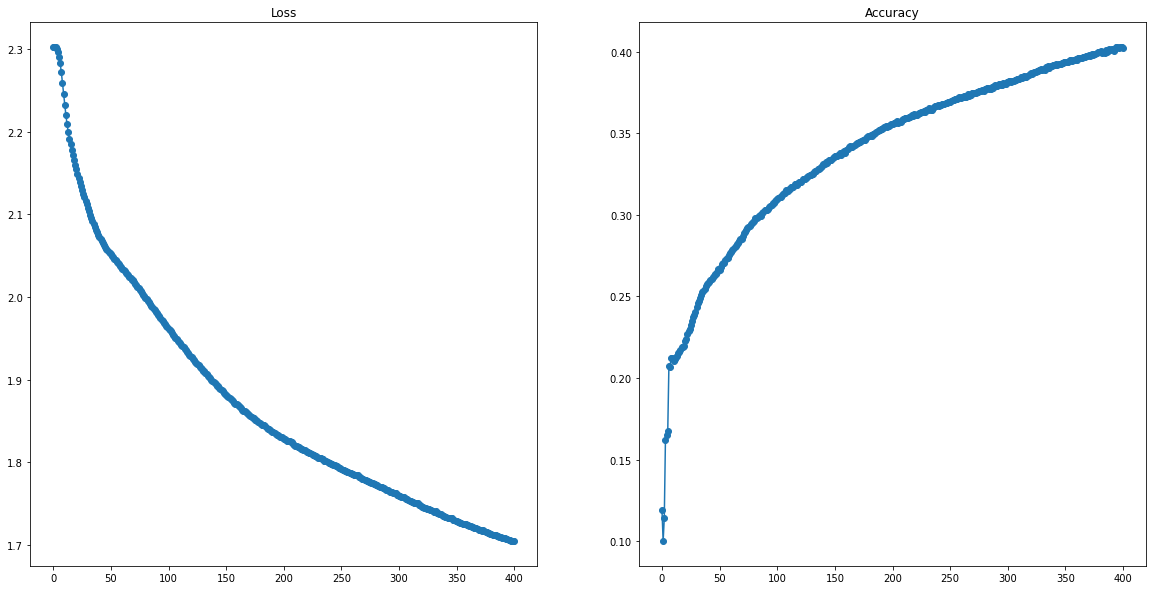

In [50]:
#Plotting
fig, ax = plt.subplots(1, 2)
ax[0].plot(LOSS_GRAPHING3)
ax[0].scatter([x for x in range(0, len(LOSS_GRAPHING3))], LOSS_GRAPHING3)
ax[0].title.set_text('Loss')

ax[1].plot(ACC_GRAPHING3)
ax[1].scatter([x for x in range(0, len(ACC_GRAPHING3))], ACC_GRAPHING3)
ax[1].title.set_text('Accuracy')

### LR decays at 1e-3

In [25]:
########## DENSE LAYER INIT ##########
dense1 = Dense_Layer(1024, 128, weight_regularizer_l2=0, bias_regularizer_l2=0)
activation1 = Activation_ReLU()
# dropout1 = Layer_Dropout(rate=0.4)  
dense2 = Dense_Layer(128, 10)
#softmax calssifiers combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

########## OPTIMIZER ##########
DECAY = 1e-3
LR = 0.01
optimizer = Optimizer_Adam(learning_rate=LR, decay=DECAY)

########## train in loop & Forward Pass ##########
EPOCHS = 2000
LOSS_GRAPHING2 = []
ACC_GRAPHING2 = []
print("starting training...")
for epoch in range(1, EPOCHS + 1):
    ########### FORWARD PASS ##########
    dense1.forward(x_train)
    activation1.forward(dense1.output)
    # dropout1.forward(activation1.output)
    dense2.forward(activation1.output)
    # loss from activation layer and softmax
    data_loss = loss_activation.forward(dense2.output, y_train)
    # loss with regularization
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2) 
    # total loss
    loss = data_loss + regularization_loss

    # accuracy and printing every 1000 epochs
    if epoch % 5 == 0 or epoch == 1:
        ########### ACCURACY ##########
        predictions = np.argmax(loss_activation.output, axis=1)
        # if targets are one hot encoded we then convert them
        if len(y_train.shape) == 2:
            y_train = np.argmax(y_train, axis=1)
        accuracy = np.mean(predictions == y_train) #if true we get 1 else 0

        # print(f"epoch {epoch} / {EPOCHS} acc:{accuracy:.3f} loss:{loss:.3f} data_loss:{data_loss:.3f} reg_loss:{regularization_loss:.3f} lr:{optimizer.current_learning_rate:.6f}")
        print(f"epoch {epoch} / {EPOCHS} acc:{accuracy:.3f} loss:{loss:.6f} lr:{optimizer.current_learning_rate:.6f}")
        LOSS_GRAPHING2.append(loss)
        ACC_GRAPHING2.append(accuracy)
    
    ########### BACKWARD PASS ##########
    loss_activation.backward(loss_activation.output, y_train)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    # dense2.backward(activation2.dinputs)
    # dropout1.backward(dense2.dinputs)
    # activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    ########## UPDATE PARAMS ##########
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

starting training...
epoch 1 / 2000 acc:0.096 loss:2.302585 lr:0.010000
epoch 5 / 2000 acc:0.100 loss:2.302494 lr:0.009970
epoch 10 / 2000 acc:0.108 loss:2.301757 lr:0.009921
epoch 15 / 2000 acc:0.187 loss:2.299611 lr:0.009872
epoch 20 / 2000 acc:0.183 loss:2.295469 lr:0.009823
epoch 25 / 2000 acc:0.182 loss:2.288981 lr:0.009775
epoch 30 / 2000 acc:0.196 loss:2.280005 lr:0.009728
epoch 35 / 2000 acc:0.194 loss:2.268856 lr:0.009681
epoch 40 / 2000 acc:0.192 loss:2.256253 lr:0.009634
epoch 45 / 2000 acc:0.199 loss:2.243134 lr:0.009588
epoch 50 / 2000 acc:0.201 loss:2.230502 lr:0.009542
epoch 55 / 2000 acc:0.204 loss:2.219152 lr:0.009497
epoch 60 / 2000 acc:0.207 loss:2.209476 lr:0.009452
epoch 65 / 2000 acc:0.209 loss:2.201411 lr:0.009407
epoch 70 / 2000 acc:0.211 loss:2.194596 lr:0.009363
epoch 75 / 2000 acc:0.213 loss:2.188567 lr:0.009320
epoch 80 / 2000 acc:0.214 loss:2.182925 lr:0.009276
epoch 85 / 2000 acc:0.214 loss:2.177708 lr:0.009234
epoch 90 / 2000 acc:0.214 loss:2.172657 lr:0.

In [26]:
########## VALIDATE THE MODEL ##########
dense1.forward(x_train)
activation1.forward(dense1.output)
# dropout1.forward(activation1.output)
dense2.forward(activation1.output)
# loss from activation layer and softmax
data_loss = loss_activation.forward(dense2.output, y_train)
# loss with regularization
regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2) 
# total loss
loss = data_loss + regularization_loss

########### ACCURACY ##########
predictions = np.argmax(loss_activation.output, axis=1)
# if targets are one hot encoded we then convert them
if len(y_train.shape) == 2:
    y_train = np.argmax(y_train, axis=1)
accuracy = np.mean(predictions == y_train) #if true we get 1 else 0

print(f"acc:{accuracy:.3f} loss:{loss:.3f} data_loss:{data_loss:.3f} reg_loss:{regularization_loss:.3f}")

acc:0.386 loss:1.751 data_loss:1.751 reg_loss:0.000


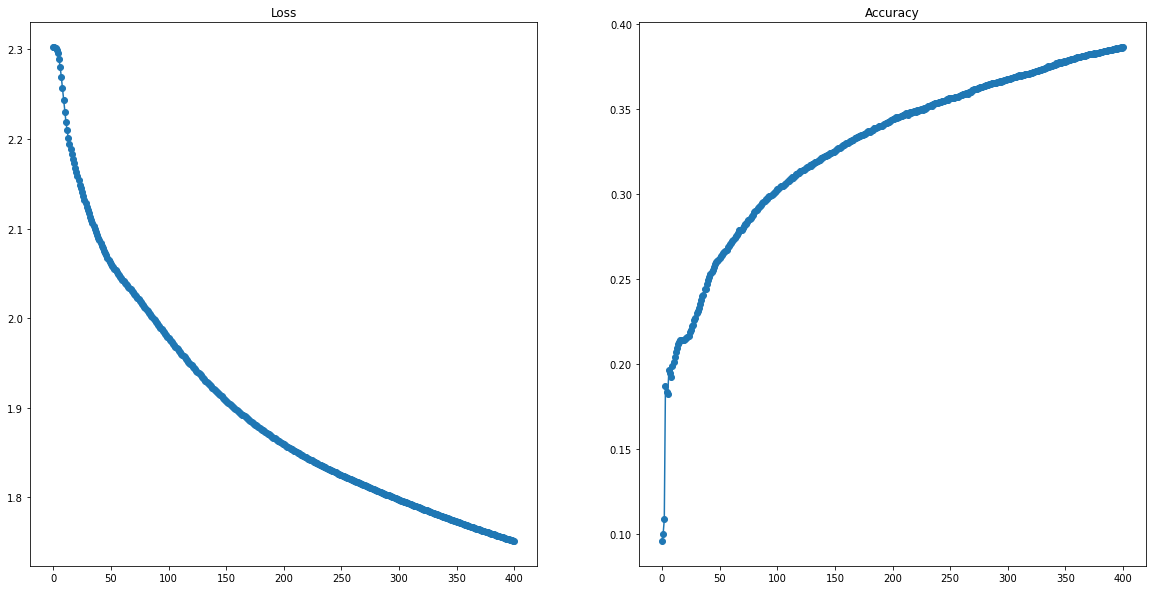

In [29]:
#Plotting
fig, ax = plt.subplots(1, 2)
ax[0].plot(LOSS_GRAPHING2)
ax[0].scatter([x for x in range(0, len(LOSS_GRAPHING2))], LOSS_GRAPHING2)
ax[0].title.set_text('Loss')

ax[1].plot(ACC_GRAPHING2)
ax[1].scatter([x for x in range(0, len(ACC_GRAPHING2))], ACC_GRAPHING2)
ax[1].title.set_text('Accuracy')

### More Dense Layers

In [25]:
########## DENSE LAYER INIT ##########
dense1 = Dense_Layer(1024, 128, weight_regularizer_l2=0, bias_regularizer_l2=0)
activation1 = Activation_ReLU()
# dropout1 = Layer_Dropout(rate=0.4)  
dense2 = Dense_Layer(128, 128)
activation2 = Activation_ReLU()
dense3 = Dense_Layer(128, 10)
#softmax calssifiers combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

########## OPTIMIZER ##########
DECAY = 1e-3
LR = 0.01
optimizer = Optimizer_Adam(learning_rate=LR, decay=DECAY)

########## train in loop & Forward Pass ##########
EPOCHS = 2000
LOSS_GRAPHING1 = []
ACC_GRAPHING1 = []
print("starting training...")
for epoch in range(1, EPOCHS + 1):
    ########### FORWARD PASS ##########
    dense1.forward(x_train)
    activation1.forward(dense1.output)
    # dropout1.forward(activation1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    # loss from activation layer and softmax
    data_loss = loss_activation.forward(dense3.output, y_train)
    # loss with regularization
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2) + loss_activation.loss.regularization_loss(dense3)
    # total loss
    loss = data_loss + regularization_loss

    # accuracy and printing every 1000 epochs
    if epoch % 5 == 0 or epoch == 1:
        ########### ACCURACY ##########
        predictions = np.argmax(loss_activation.output, axis=1)
        # if targets are one hot encoded we then convert them
        if len(y_train.shape) == 2:
            y_train = np.argmax(y_train, axis=1)
        accuracy = np.mean(predictions == y_train) #if true we get 1 else 0

        # print(f"epoch {epoch} / {EPOCHS} acc:{accuracy:.3f} loss:{loss:.3f} data_loss:{data_loss:.3f} reg_loss:{regularization_loss:.3f} lr:{optimizer.current_learning_rate:.6f}")
        print(f"epoch {epoch} / {EPOCHS} acc:{accuracy:.3f} loss:{loss:.6f} lr:{optimizer.current_learning_rate:.6f}")
        LOSS_GRAPHING1.append(loss)
        ACC_GRAPHING1.append(accuracy)
    
    ########### BACKWARD PASS ##########
    loss_activation.backward(loss_activation.output, y_train)
    dense3.backward(loss_activation.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    # dropout1.backward(dense2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    ########## UPDATE PARAMS ##########
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

starting training...
epoch 1 / 2000 acc:0.100 loss:2.302585 lr:0.010000
epoch 5 / 2000 acc:0.100 loss:2.302604 lr:0.009970
epoch 10 / 2000 acc:0.102 loss:2.302591 lr:0.009921
epoch 15 / 2000 acc:0.100 loss:2.302587 lr:0.009872
epoch 20 / 2000 acc:0.100 loss:2.302586 lr:0.009823
epoch 25 / 2000 acc:0.100 loss:2.302585 lr:0.009775
epoch 30 / 2000 acc:0.100 loss:2.302584 lr:0.009728
epoch 35 / 2000 acc:0.100 loss:2.302579 lr:0.009681
epoch 40 / 2000 acc:0.126 loss:2.302549 lr:0.009634
epoch 45 / 2000 acc:0.102 loss:2.302506 lr:0.009588
epoch 50 / 2000 acc:0.100 loss:2.302199 lr:0.009542
epoch 55 / 2000 acc:0.100 loss:2.301548 lr:0.009497
epoch 60 / 2000 acc:0.130 loss:2.300079 lr:0.009452
epoch 65 / 2000 acc:0.150 loss:2.296875 lr:0.009407
epoch 70 / 2000 acc:0.148 loss:2.290591 lr:0.009363
epoch 75 / 2000 acc:0.154 loss:2.280468 lr:0.009320
epoch 80 / 2000 acc:0.155 loss:2.266897 lr:0.009276
epoch 85 / 2000 acc:0.149 loss:2.251298 lr:0.009234
epoch 90 / 2000 acc:0.147 loss:2.236710 lr:0.

In [38]:
#Plotting
fig, ax = plt.subplots(1, 2)
ax[0].plot(LOSS_GRAPHING1)
ax[0].scatter([x for x in range(0, len(LOSS_GRAPHING1), 5)], LOSS_GRAPHING1)
ax[0].title.set_text('Loss')

ax[1].plot(ACC_GRAPHING1)
ax[1].scatter([x for x in range(0, len(ACC_GRAPHING1), 5)], ACC_GRAPHING1)
ax[1].title.set_text('Accuracy')